In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
import datetime
from numpy import array

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [96]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [4]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [5]:
police_shooting = pd.read_csv('US Police shootings in from 2015-22_Clean.csv')
police_shooting['date'] = pd.to_datetime(police_shooting['date'])
us_population_by_state = pd.read_csv('nst-est2021-popchg2010-2022.csv')

In [6]:
police_shooting

,date,armed,age,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude
0,2015-01-02,gun,53.0,American Native,Shelton,Washington,True,attack,Not fleeing,False,-123.122,47.247
1,2015-01-02,gun,47.0,White,Aloha,Oregon,False,attack,Not fleeing,False,-122.892,45.487
2,2015-01-03,unarmed,23.0,Hispanic,Wichita,Kansas,False,other,Not fleeing,False,-97.281,37.695
3,2015-01-04,toy gun,32.0,White,San Francisco,California,True,attack,Not fleeing,False,-122.422,37.763
4,2015-01-04,miscellaneous lethal weapons,39.0,Hispanic,Evans,Colorado,False,attack,Not fleeing,False,-104.692,40.384
...,...,...,...,...,...,...,...,...,...,...,...,...
7724,2022-09-07,sharp object,35.0,NG,Flagstaff,Arizona,False,other,Foot,False,-111.584,35.224
7725,2022-09-07,gun,35.0,White,Springville,Alabama,False,attack,Car,False,-86.472,33.775
7726,2022-09-07,knife,61.0,Black,St. Louis,Missouri,False,other,Not fleeing,False,-90.290,38.668
7727,2022-09-07,gun,27.0,NG,Washington County,Tennessee,False,attack,Other,False,-82.539,36.309


In [7]:
def filter_data(df: pd.DataFrame, state: str = None, race: str= None, armed: str = None, flee: str = None):    
    columns: list[str] = ['date']
    query: list[str] = []
    
    if state:
        columns.append('state')
        query.append(f'state == "{state}"')
    if race:
        columns.append('race')
        query.append(f'race == "{race}"')
    if armed:
        columns.append('armed')
        query.append(f'armed == "{armed}"')
    if flee:
        columns.append('flee')
        query.append(f'flee == "{flee}"')
    
    df = df[columns].reset_index(drop=True)
    df = df.query(' and '.join(query))
    return df

In [8]:
def resample(df: pd.DataFrame, sample: str):
    df = df.set_index('date')
    
    df1 = df.resample(sample).agg({ df.columns[0]: 'size' })
    df1 = df1.rename({df.columns[0]: 'count'}, axis=1)
    # for index, column in enumerate(df.columns):
    #     df1.insert(index, column, df[column].iloc[0])
    return df1

In [9]:
def extract_date_feature(date: datetime.datetime):
    return sin_transformer(12).fit_transform(date.month), cos_transformer(12).fit_transform(date.month), sin_transformer(365).fit_transform(date.timetuple().tm_yday), cos_transformer(12).fit_transform(date.timetuple().tm_yday)

In [10]:
def extract_date_feature_from_df(df: pd.DataFrame):
    df.insert(0, "month", df.index.month)
    df.insert(1, "day_of_year", df.index.day_of_year)
    
    df.insert(2, "month_sin", sin_transformer(12).fit_transform(df["month"]))
    df.insert(3, "month_cos", cos_transformer(12).fit_transform(df["month"]))

    df.insert(4, "day_sin", sin_transformer(365).fit_transform(df["day_of_year"]))
    df.insert(5, "day_cos", cos_transformer(365).fit_transform(df["day_of_year"]))
    
    df.drop(columns=['month', 'day_of_year'], inplace=True)
    
    return df

In [164]:
dataset = extract_date_feature_from_df(resample(filter_data(police_shooting, state='Washington', race='White'), 'W'))
dataset = dataset.rename({'count': 'y'}, axis=1)
dataset['y'] = dataset['y'].astype(int)

In [165]:
for i in range(1, 6):
    dataset['y_{}'.format(i)] = dataset.y.shift(i).fillna(0).astype(int)
dataset = dataset.iloc[5:, :].reset_index(drop=True)

In [166]:
new_col_list = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y']
dataset = dataset.reindex(columns=new_col_list)

In [167]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.30, random_state=0)

In [168]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = [], []
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		X.append(sequences.iloc[i:end_ix, :-1]), y.append(sequences.iloc[end_ix-1, -1])
	return np.array(X), np.array(y)

In [169]:
X_train, Y_train = split_sequences(dataset_train, 24)
X_test, Y_test = split_sequences(dataset_test, 24)

In [171]:
simodel = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
simodel.compile(loss='mse', optimizer='adam')
simodel.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 100)               44000     
                                                                 
 dense_18 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44,101
Trainable params: 44,101
Non-trainable params: 0
_________________________________________________________________


In [172]:
si_mode_history = simodel.fit(X_train, Y_train, epochs=30, batch_size=4, validation_data=(X_test, Y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Epoch 1/30
57/57 [==============================] - 1s 11ms/step - loss: 0.2099 - val_loss: 0.3438
Epoch 2/30
57/57 [==============================] - 0s 7ms/step - loss: 0.2021 - val_loss: 0.3532
Epoch 3/30
57/57 [==============================] - 0s 8ms/step - loss: 0.1982 - val_loss: 0.3647
Epoch 4/30
57/57 [==============================] - 0s 8ms/step - loss: 0.1948 - val_loss: 0.3824
Epoch 5/30
57/57 [==============================] - 0s 9ms/step - loss: 0.1905 - val_loss: 0.4043
Epoch 6/30
57/57 [==============================] - 0s 7ms/step - loss: 0.1855 - val_loss: 0.5444
Epoch 7/30
57/57 [==============================] - 1s 9ms/step - loss: 0.1799 - val_loss: 1.4182
Epoch 8/30
57/57 [==============================] - 1s 9ms/step - loss: 0.1760 - val_loss: 0.4927
Epoch 9/30
57/57 [==============================] - 0s 7ms/step - loss: 0.1725 - val_loss: 0.3702
Epoch 10/30
57/57 [==============================] - 0s 7ms/step - loss: 0.1625 - val_loss: 0.4315
Epoch 11/30
57/57 

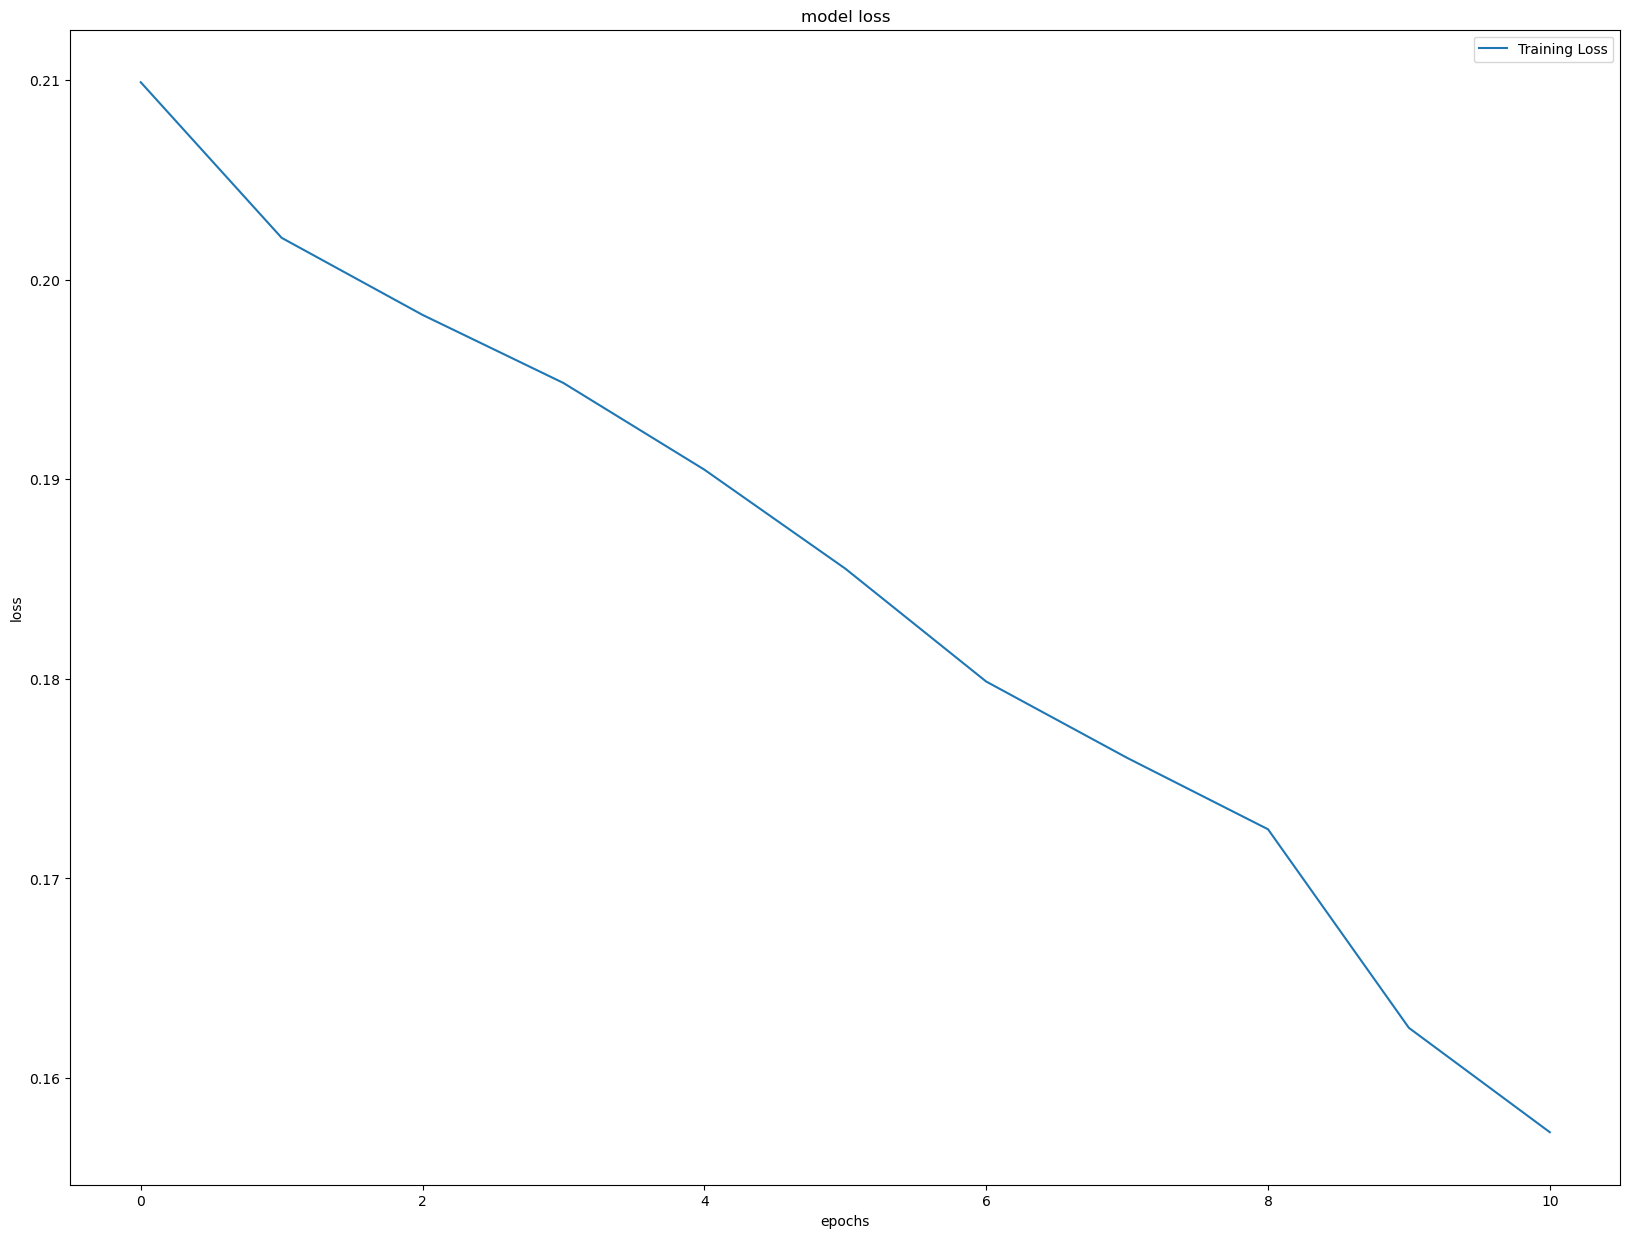

In [173]:
plt.figure(figsize=(20,15))
plt.plot(si_mode_history.history['loss'], label='Training Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [174]:
prediction_result = simodel.predict(X_test)

3/3 [==============================] - 0s 6ms/step


In [175]:
prediction_result.flatten().astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [176]:
Y_test

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 1, 0, 1, 0])

In [177]:
print('Test Mean Absolute Error:', mean_squared_error(Y_test, prediction_result.flatten()))

Test Mean Absolute Error: 0.5800297892699047
